In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,6)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/lending_club_data/accepted_2007_to_2018Q4.csv",low_memory=False)


In [ ]:
df.shape

(2260701, 151)

### Initial Feature selection

In [ ]:
df.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

That's a lot of columns right there, we need to use features that are relevant to our Goal and had no leakage.

In [ ]:
model_features = [
    # Borrower info
    'annual_inc', 'verification_status', 'emp_length', 'home_ownership', 'addr_state',
    'dti', 'purpose', 'application_type',

    # Credit risk indicators
    'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
    'mths_since_last_record', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'collections_12_mths_ex_med', 'mths_since_last_major_derog',
    'delinq_2yrs', 'acc_now_delinq', 'num_tl_90g_dpd_24m',

    # Loan application terms
    'loan_amnt', 'int_rate', 'term', 'installment', 'grade', 'sub_grade',
    'funded_amnt',

    # status
    'loan_status'
]


In [ ]:
model_df = df[model_features].copy()

### Default encoding

In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


There are a lot of thing in loan status including **in-progress and exeptional loans** which we don't want to train our model with so, we'll only use **Fully paid** and **Charged off** status.

In [ ]:
keep_statuses = [
    'Fully Paid', 'Charged Off', 'Default',
    'Does not meet the credit policy. Status: Fully Paid',
    'Does not meet the credit policy. Status: Charged Off'
]

model_df = model_df[model_df['loan_status'].isin(keep_statuses)]

default_statuses = ['Charged Off', 'Default', 'Does not meet the credit policy. Status: Charged Off']

model_df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)

In [ ]:
model_df['loan_status'].value_counts()

,count
loan_status,
0,1076751
1,268599


### EDA

In [ ]:
model_df.head()

,annual_inc,verification_status,emp_length,home_ownership,addr_state,dti,purpose,application_type,fico_range_low,fico_range_high,...,acc_now_delinq,num_tl_90g_dpd_24m,loan_amnt,int_rate,term,installment,grade,sub_grade,funded_amnt,loan_status
0,55000.0,Not Verified,10+ years,MORTGAGE,PA,5.91,debt_consolidation,Individual,675.0,679.0,...,0.0,0.0,3600.0,13.99,36 months,123.03,C,C4,3600.0,0
1,65000.0,Not Verified,10+ years,MORTGAGE,SD,16.06,small_business,Individual,715.0,719.0,...,0.0,0.0,24700.0,11.99,36 months,820.28,C,C1,24700.0,0
2,63000.0,Not Verified,10+ years,MORTGAGE,IL,10.78,home_improvement,Joint App,695.0,699.0,...,0.0,0.0,20000.0,10.78,60 months,432.66,B,B4,20000.0,0
4,104433.0,Source Verified,3 years,MORTGAGE,PA,25.37,major_purchase,Individual,695.0,699.0,...,0.0,0.0,10400.0,22.45,60 months,289.91,F,F1,10400.0,0
5,34000.0,Source Verified,4 years,RENT,GA,10.20,debt_consolidation,Individual,690.0,694.0,...,0.0,0.0,11950.0,13.44,36 months,405.18,C,C3,11950.0,0


In [ ]:
model_df['verification_status'].value_counts()

,count
verification_status,
Source Verified,521289
Verified,418352
Not Verified,405709


Income verified count.

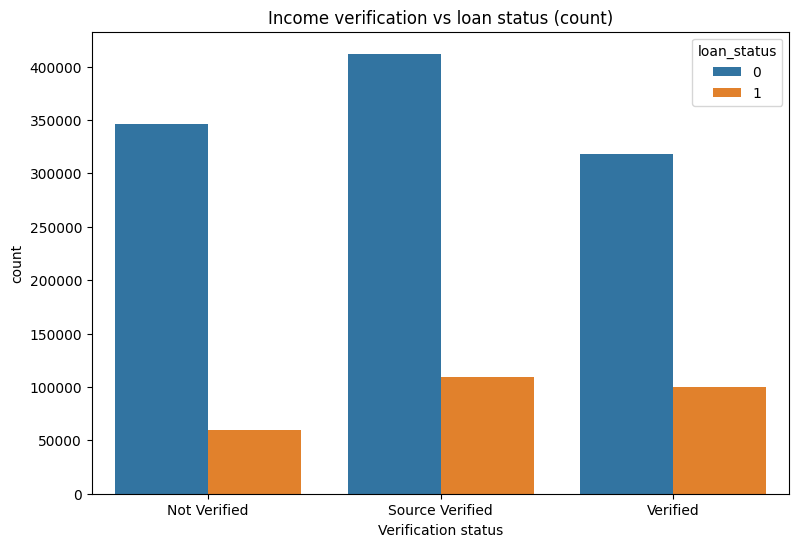

In [ ]:
verf_count = model_df.groupby('verification_status')['loan_status'].value_counts().reset_index()
sns.barplot(data=verf_count,x='verification_status',y='count',hue='loan_status')
plt.title('Income verification vs loan status (count)')
plt.xlabel('Verification status')
plt.show()


In [ ]:
model_df.groupby('verification_status')['loan_status'].mean()

,loan_status
verification_status,
Not Verified,0.146763
Source Verified,0.209573
Verified,0.238574


1.  We expected unverified borrowers to default more often — but here, verified borrowers have higher default rates.
2.  If you verify income more often for risky applicants, the group called “Verified” will naturally include more high-risk borrowers.

In [ ]:
model_df.groupby('verification_status')[['fico_range_low', 'annual_inc', 'dti']].mean()

,fico_range_low,annual_inc,dti
verification_status,,,
Not Verified,703.665361,69823.029922,17.674340
Source Verified,693.012436,80573.597414,17.510330
Verified,692.884700,77087.508000,19.834426


*  Bingo! **Verified** group has **lower FICO** and **high DTI** percent on average.
*  The income verification process is not random, it’s targeted toward higher-risk applicants.


---



In [ ]:
model_df['home_ownership'].value_counts()


,count
home_ownership,
MORTGAGE,665596
RENT,534436
OWN,144840
ANY,286
OTHER,144
NONE,48


We can ignore **Any, Other** and **None** home ownership titles or just group them into one.

In [ ]:
df['home_ownership_clean'] = df['home_ownership'].replace({'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER'})

In [ ]:
home_ownership = model_df.groupby('home_ownership')['loan_status'].mean().sort_values(ascending=False)
home_ownership

,loan_status
home_ownership,
RENT,0.232187
OWN,0.206241
ANY,0.195804
OTHER,0.187500
MORTGAGE,0.172098
NONE,0.145833


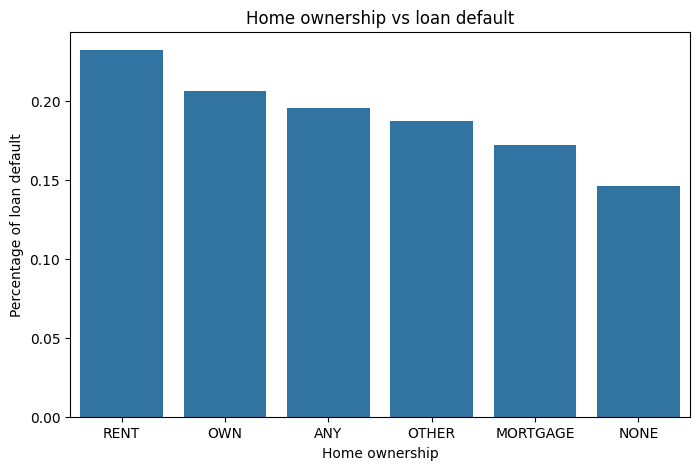

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=home_ownership)
plt.xlabel('Home ownership')
plt.ylabel('Percentage of loan default')
plt.title('Home ownership vs loan default')
plt.show()

**Mortgage holders default less, maybe because of stable high income**.

In [ ]:
model_df.groupby('home_ownership')[['fico_range_low', 'annual_inc', 'dti']].mean().sort_values(by='dti',ascending=False)


,fico_range_low,annual_inc,dti
home_ownership,,,
NONE,691.979167,62798.979167,20.750000
OWN,698.094863,71251.974038,18.711179
ANY,702.622378,79109.977168,18.709406
MORTGAGE,699.307395,86233.737830,18.373509
RENT,691.773262,65166.310362,18.053959
OTHER,707.395833,68374.180556,14.344167




---



In [ ]:
model_df['purpose'].value_counts()

,count
purpose,
debt_consolidation,780342
credit_card,295285
home_improvement,87507
other,77877
major_purchase,29427
medical,15556
small_business,15416
car,14588
moving,9480


**There are high number of debt consolidation loans, next we have credit card loans.**

In [ ]:
model_df.groupby('purpose')[['loan_status']].mean().sort_values(by='loan_status',ascending=False)

,loan_status
purpose,
small_business,0.297094
renewable_energy,0.236870
moving,0.233544
house,0.218914
medical,0.217858
debt_consolidation,0.211491
other,0.210422
vacation,0.191726
major_purchase,0.186054



*    Small Business Loans = High Risk
*   Debt Consolidation = High Volume, Moderate Risk.
*  Some Rare Purposes = High Default E.g., **renewable_energy, moving, house**
*  **Weddings, Cars, Credit Cards** = Safer


---





In [ ]:
model_df['application_type'].value_counts()

,count
application_type,
Individual,1319544
Joint App,25806


**98% loans are taken by Individuals.**

In [ ]:
model_df.groupby('application_type')[['fico_range_low','annual_inc','dti','loan_status']].mean()

,fico_range_low,annual_inc,dti,loan_status
application_type,,,,
Individual,696.026597,76609.925217,18.015546,0.198742
Joint App,704.297838,57719.431705,32.140656,0.246067


*  Joint applicants has a higher **default rate** and **DTI**, despite having a higher FICO score.

In [ ]:
state_default = model_df.groupby('addr_state')[['fico_range_low','annual_inc','dti','loan_status']].mean().sort_values(by='loan_status',ascending=False)
state_default

,fico_range_low,annual_inc,dti,loan_status
addr_state,,,,
MS,693.705981,69504.101963,20.532946,0.260777
NE,694.577524,64363.504108,20.152262,0.251813
AR,696.825918,66642.418091,20.170930,0.240868
AL,695.627521,68886.390844,20.141476,0.236321
OK,696.806042,70690.718451,19.892196,0.234753
LA,697.796955,74653.461884,19.351308,0.231821
NY,696.938843,79389.289156,16.556984,0.220484
NV,693.746731,71920.547903,18.531141,0.219223
FL,694.716455,71383.077086,18.489499,0.214787


/tmp/ipython-input-25-3250651024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_default.index, y=state_default['loan_status'], palette='Reds_r')


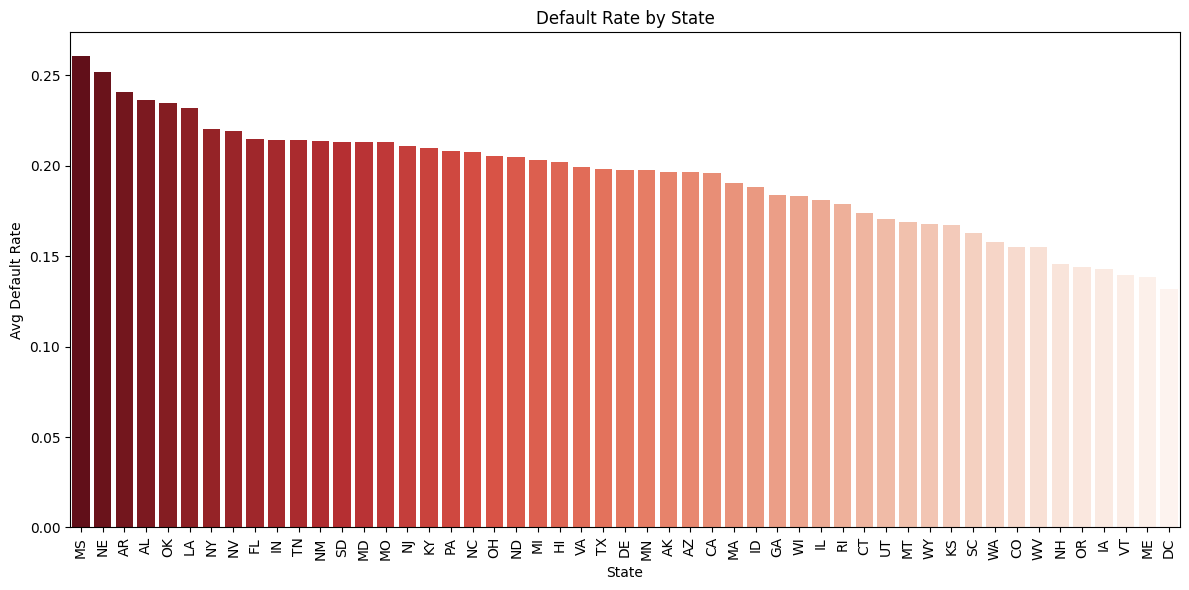

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=state_default.index, y=state_default['loan_status'], palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Default Rate by State')
plt.ylabel('Avg Default Rate')
plt.xlabel('State')
plt.tight_layout()
plt.show()

* **Highest default**: **Mississippi (MS)** at **26.1%**, with high DTI and low income.
* **High-risk range (23–25%)**: NE, AR, AL, OK, LA — all with high DTI and modest income.
* **Lowest default**: **District of Columbia (DC)** at **13.2%**, highest income, lowest DTI.
* **Low-risk range (13.8–15.8%)**: ME, VT, IA, NH, OR, WA — low DTI, strong credit or income.


---




/tmp/ipython-input-26-1185554947.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dti_default_rate = (model_df.groupby(pd.cut(model_df['dti'], bins=bins, labels=labels))['loan_status'].mean())


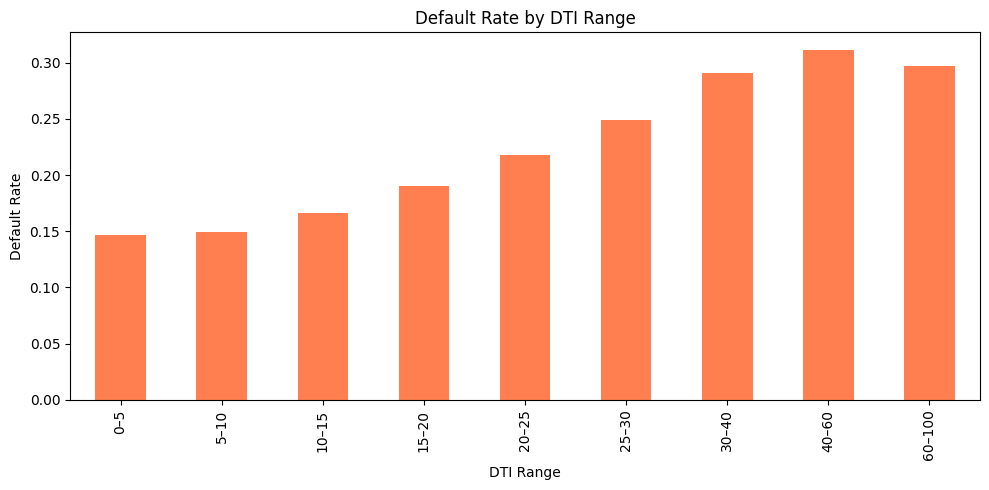

In [ ]:
bins = [0, 5, 10, 15, 20, 25, 30, 40, 60, 100]
labels = [f'{bins[i]}–{bins[i+1]}' for i in range(len(bins) - 1)]

dti_default_rate = (model_df.groupby(pd.cut(model_df['dti'], bins=bins, labels=labels))['loan_status'].mean())

dti_default_rate.plot(kind='bar', color='coral', figsize=(10, 5))
plt.title('Default Rate by DTI Range')
plt.xlabel('DTI Range')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()


**As DTI increases chance of default aslo increses.**

In [ ]:
grade_vs_default = model_df.groupby('grade')['loan_status'].value_counts().reset_index()
grade_vs_default

,grade,loan_status,count
0,A,0,220889
1,A,1,14206
2,B,0,340172
3,B,1,52576
4,C,0,296037
5,C,1,85657
6,D,0,139899
7,D,1,61067
8,E,0,57615
9,E,1,36041


In [ ]:
default_rate = model_df.groupby('grade')['loan_status'].mean().sort_values(ascending=False)
default_rate

,loan_status
grade,
G,0.499343
F,0.452042
E,0.384823
D,0.303867
C,0.224413
B,0.133867
A,0.060427


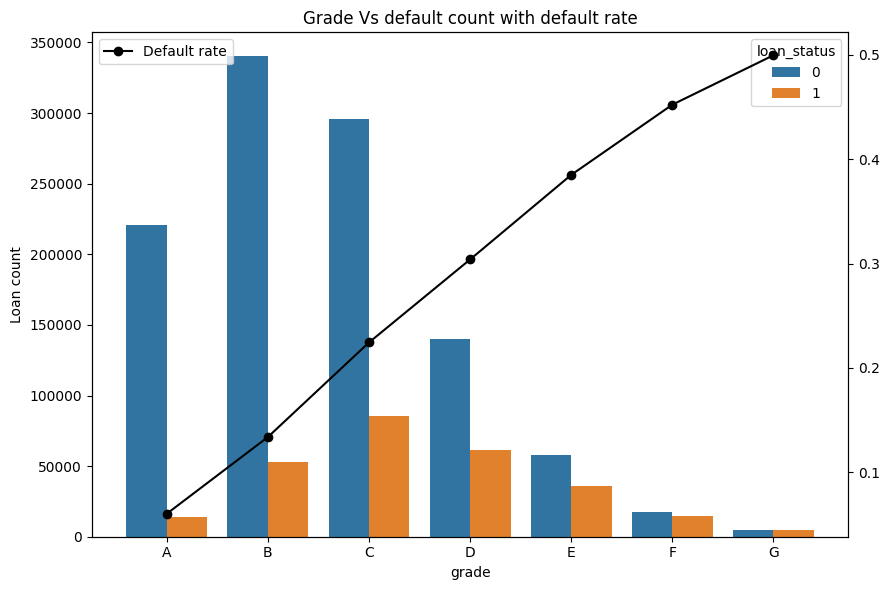

In [ ]:
fig, ax1 = plt.subplots()

sns.barplot(data=grade_vs_default,x='grade',y='count',hue='loan_status')
ax1.set_ylabel('Loan count')

ax2 = ax1.twinx()
ax2.plot(default_rate.index,default_rate.values,color='black',marker='o',label='Default rate')
ax2.legend(loc='upper left')
plt.title('Grade Vs default count with default rate')
plt.tight_layout()
plt.show()



1.   grade **B** and **C** have the highest number of total loans issued.Grade **A** follows, and volumes decrease significantly from **D to G**(least).
2.   Default rate increase in proportion as you move from Grade**A to G**.



---



In [ ]:
model_df['annual_inc'].min(), model_df['annual_inc'].max()

(0.0, 10999200.0)

In [ ]:
#99% of borrowers income
model_df['annual_inc'].quantile(0.99)

np.float64(250000.0)

Thas's a lot of difference in 99% and Top 1%.

In [ ]:
model_df['annual_inc'].skew(), model_df['annual_inc'].kurtosis()

(np.float64(46.31710885080403), np.float64(4812.356969943845))

/tmp/ipython-input-33-3961370647.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = model_df.groupby(


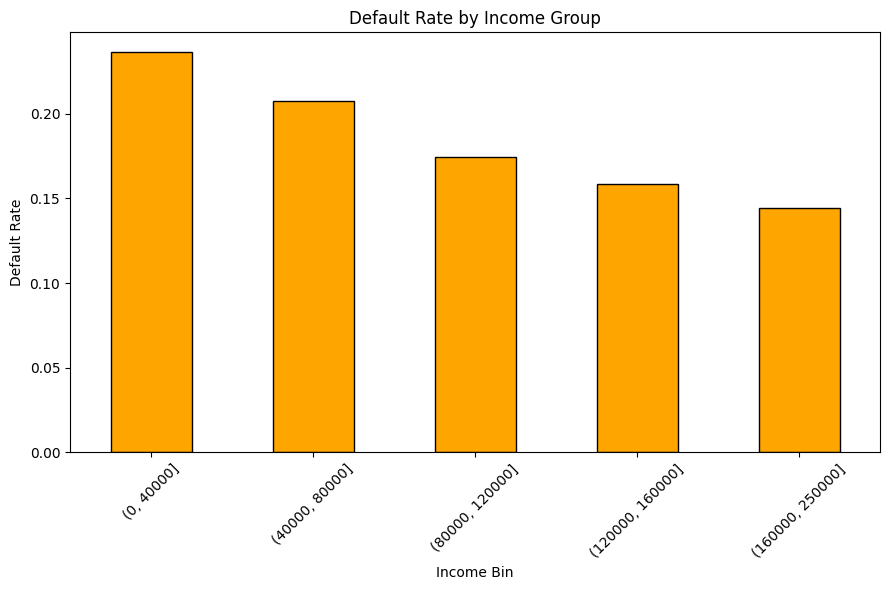

In [ ]:
default_rate_by_bin = model_df.groupby(
    pd.cut(model_df['annual_inc'].clip(upper=250000), bins=[0, 40000, 80000, 120000, 160000, 250000])
)['loan_status'].mean()

default_rate_by_bin.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Default Rate by Income Group')
plt.xlabel('Income Bin')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*  The lowest income group (0–40,000) has the highest default rate, over 23%.

*  As income increases, the default rate steadily declines.

In [ ]:
top1 = model_df[model_df['annual_inc'] > model_df['annual_inc'].quantile(0.99)]
top1.groupby('annual_inc')['loan_status'].mean().sort_values()

,loan_status
annual_inc,
995000.0,0.0
432000.0,0.0
431700.0,0.0
428258.0,0.0
427000.0,0.0
...,...
5588951.0,1.0
5400000.0,1.0
250900.0,1.0


Top **1%** income range default rate is between **0 - 1%**.


---



In [ ]:
term_default = model_df.groupby('term')['loan_status'].mean()
term_default

,loan_status
term,
36 months,0.159955
60 months,0.324485


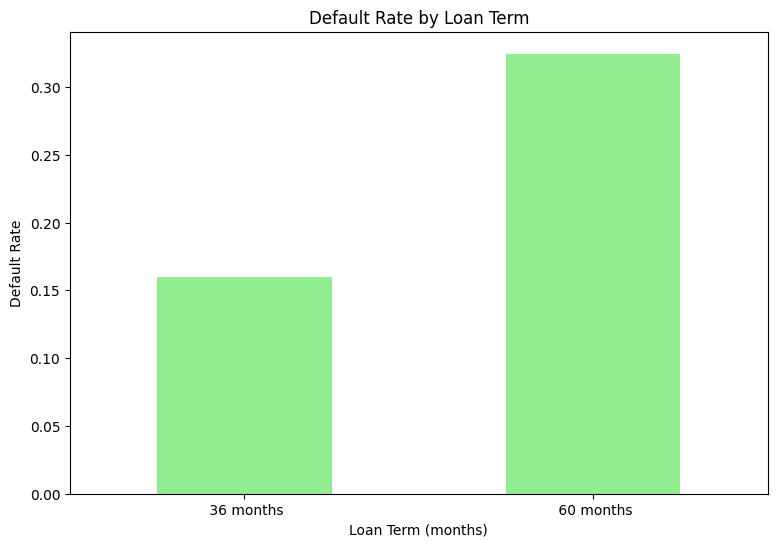

In [ ]:
term_default.plot(kind='bar',color='lightgreen')
plt.title('Default Rate by Loan Term')
plt.ylabel('Default Rate')
plt.xlabel('Loan Term (months)')
plt.xticks(rotation=0)
plt.show()

**Default probability increases with term.**


---



In [ ]:
length_default = model_df.groupby('emp_length')['loan_status'].mean().sort_values(ascending=False)
length_default

,loan_status
emp_length,
1 year,0.205650
< 1 year,0.205302
3 years,0.199727
8 years,0.199377
9 years,0.199011
2 years,0.198126
4 years,0.197398
5 years,0.196010
7 years,0.194888


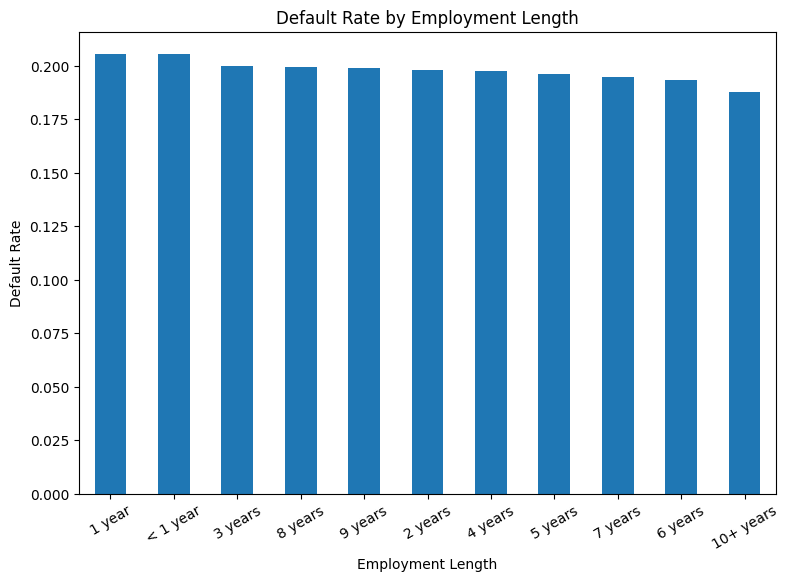

In [ ]:
length_default.plot(kind='bar')
plt.xlabel('Employment Length')
plt.xticks(rotation=30)
plt.ylabel('Default Rate')
plt.title('Default Rate by Employment Length')
plt.show()

*  There is no much difference in employment length and default rate but it's always the longer the better.


---



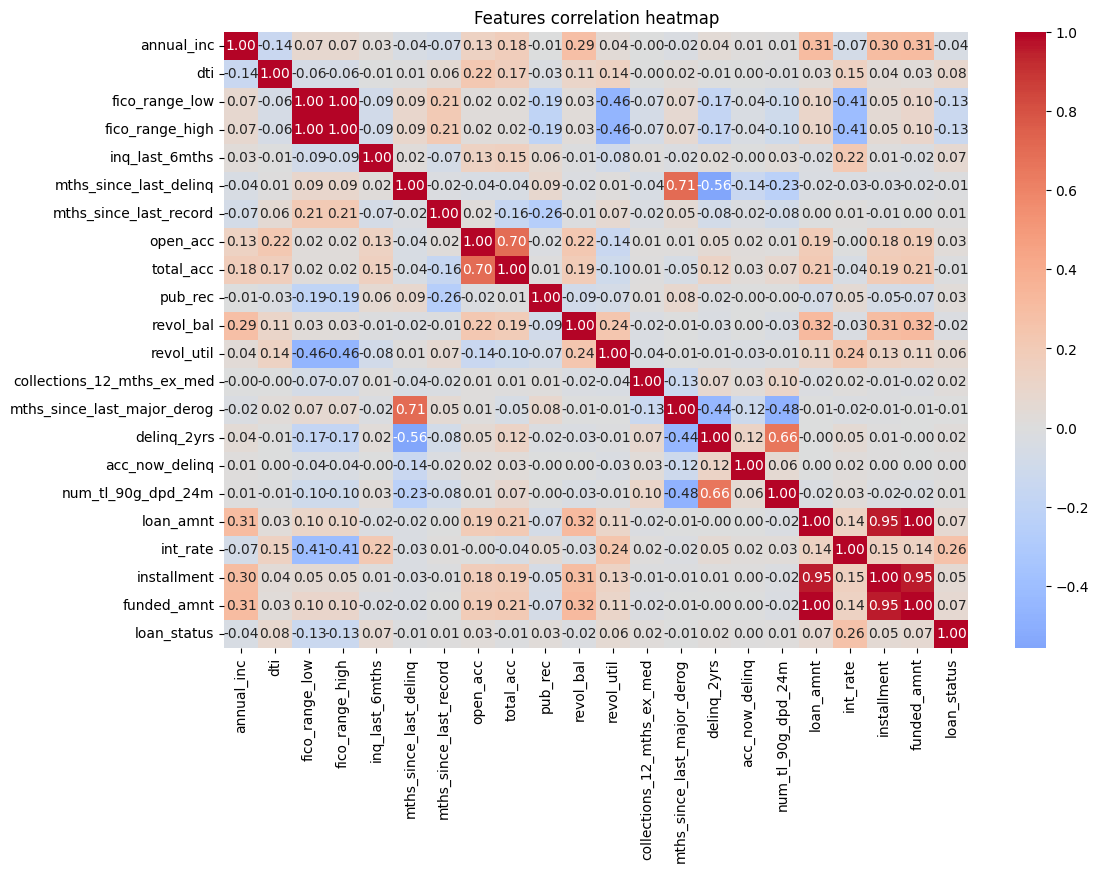

In [ ]:
df_numeric = model_df.select_dtypes(include='number')
corr = df_numeric.corr()

plt.figure(figsize=(12,8))
plt.title('Features correlation heatmap')
sns.heatmap(data=corr,annot=True,fmt='.2f',cmap='coolwarm',center=0)
plt.show()



*   Features have weak correlation with **Loan_status**, we need to go for non linear models.
*   loan_amnt, installment, and funded_amnt are highly correlated (all >0.9)
*  we need to do more future engineering here.



### Analyzing and Handling missing values

In [ ]:
model_df.isnull().sum()

,0
annual_inc,0
verification_status,0
emp_length,78516
home_ownership,0
addr_state,0
dti,374
purpose,0
application_type,0
fico_range_low,0
fico_range_high,0


In [ ]:
model_df['emp_length'].unique()

array(['10+ years', '3 years', '4 years', '6 years', '7 years', '8 years',
       '2 years', '5 years', '9 years', '< 1 year', '1 year', nan],
      dtype=object)

In [ ]:
model_df['emp_length'] = model_df['emp_length'].fillna('unknown')

WE can keep it as categorical by adding unknown for missing emp_length.

In [ ]:
model_df['dti'] = model_df['dti'].fillna(model_df['dti'].median())

In [ ]:
model_df['mths_since_last_delinq'] = model_df['mths_since_last_delinq'].fillna(999)
model_df['mths_since_last_record'] = model_df['mths_since_last_record'].fillna(999)
model_df['mths_since_last_major_derog'] = model_df['mths_since_last_major_derog'].fillna(999)
model_df['num_tl_90g_dpd_24m'] = model_df['num_tl_90g_dpd_24m'].fillna(-1)

for linear models we'll add dummy number and for non linear models it'll work even Nans.

In [ ]:
model_df['revol_util'] = model_df['revol_util'].fillna(model_df['revol_util'].median())

In [ ]:
model_df['collections_12_mths_ex_med'] = model_df['collections_12_mths_ex_med'].fillna(0)

In lending models, a missing here usually means "no collections" — impute with 0 is safe.

### Inspecting data types

In [ ]:
model_df.dtypes

,0
annual_inc,float64
verification_status,object
emp_length,object
home_ownership,object
addr_state,object
dti,float64
purpose,object
application_type,object
fico_range_low,float64
fico_range_high,float64


**We can do label encoding(or leave as it) for tree models and do one-hot encoding for linear models.**

### Outliers and Skewness check

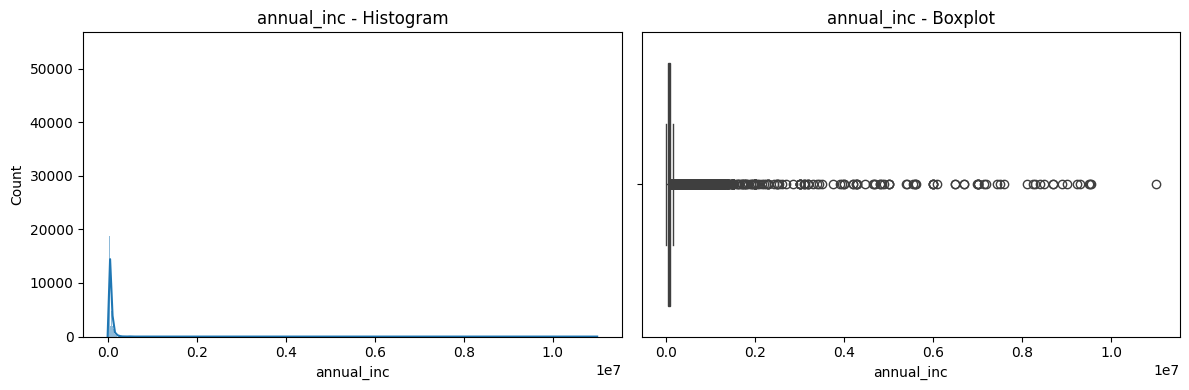

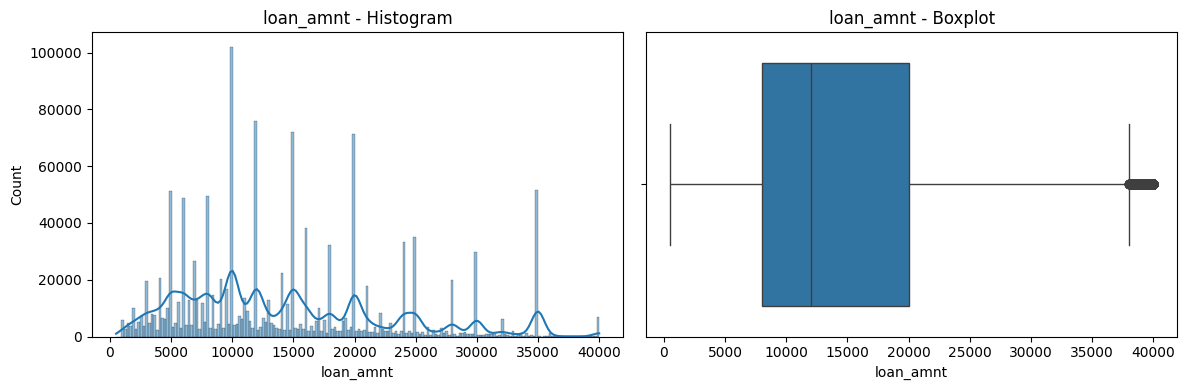

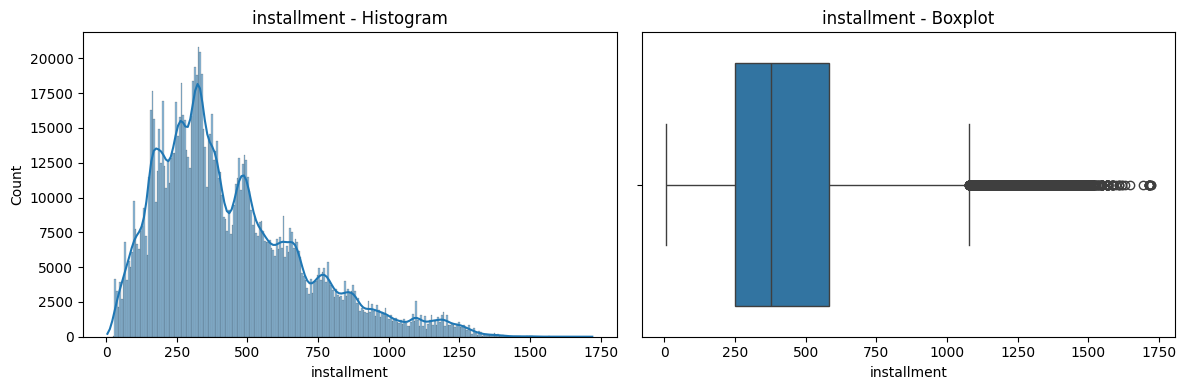

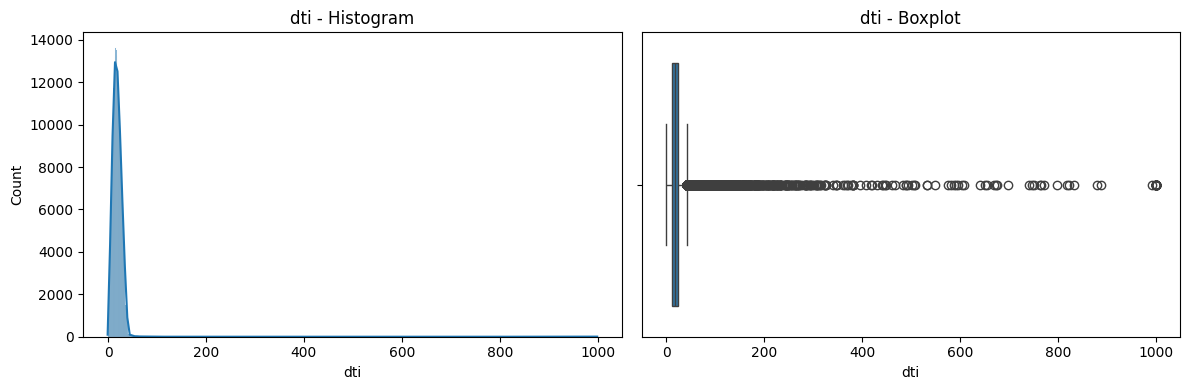

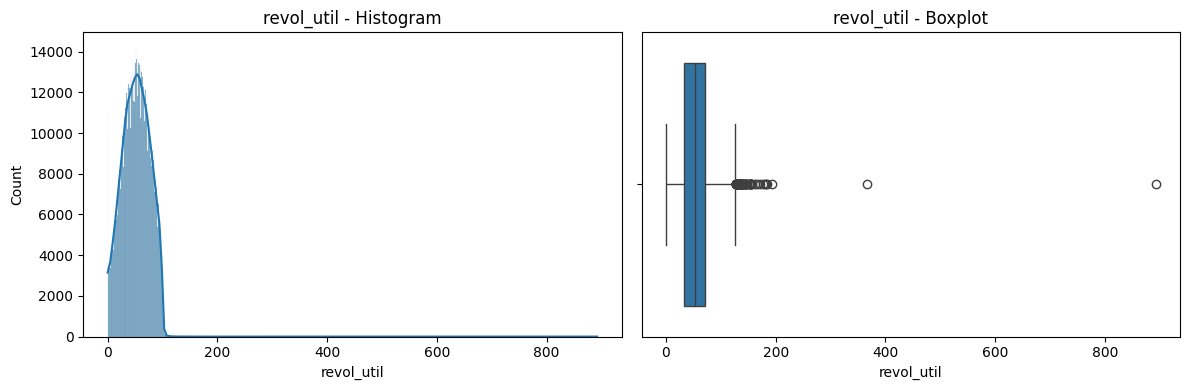

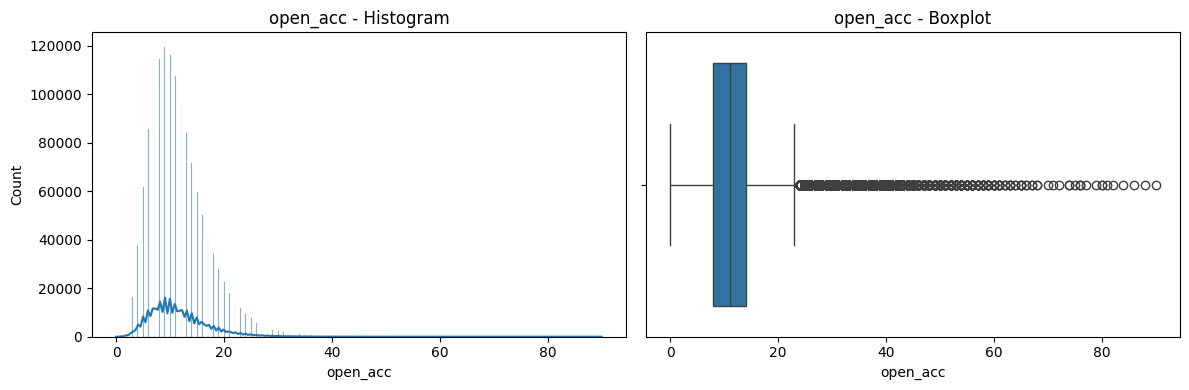

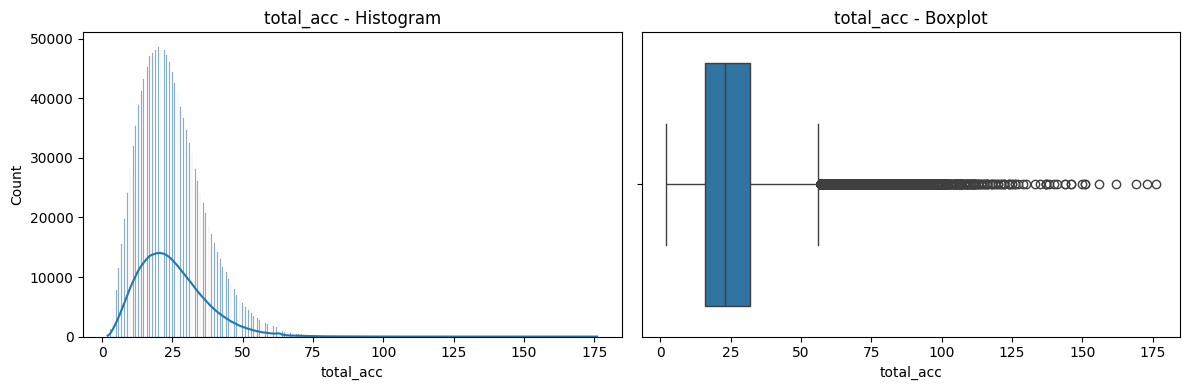

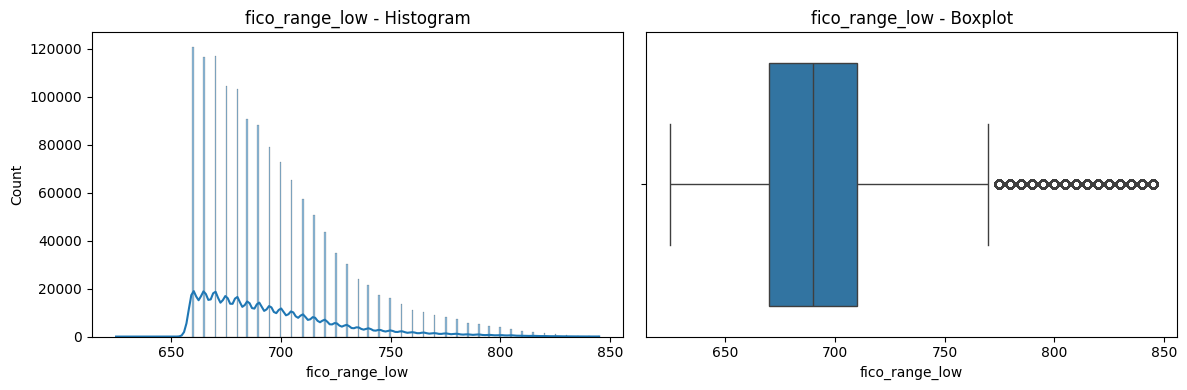

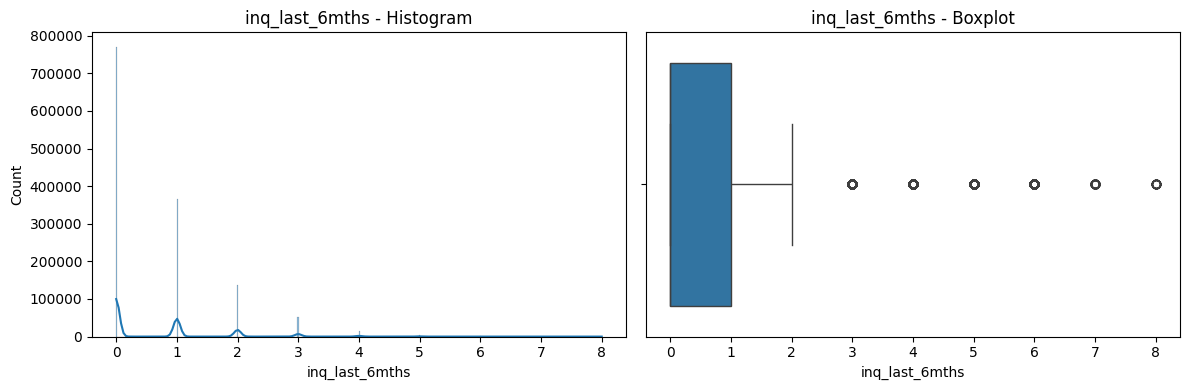

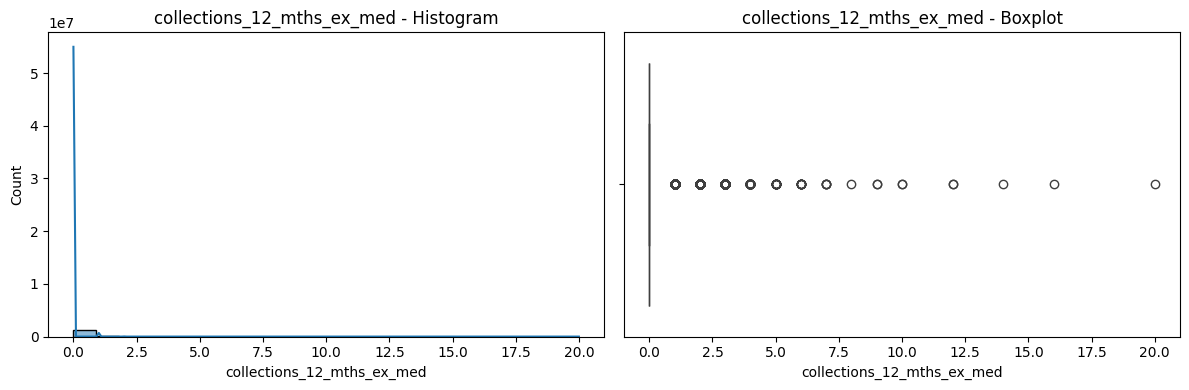

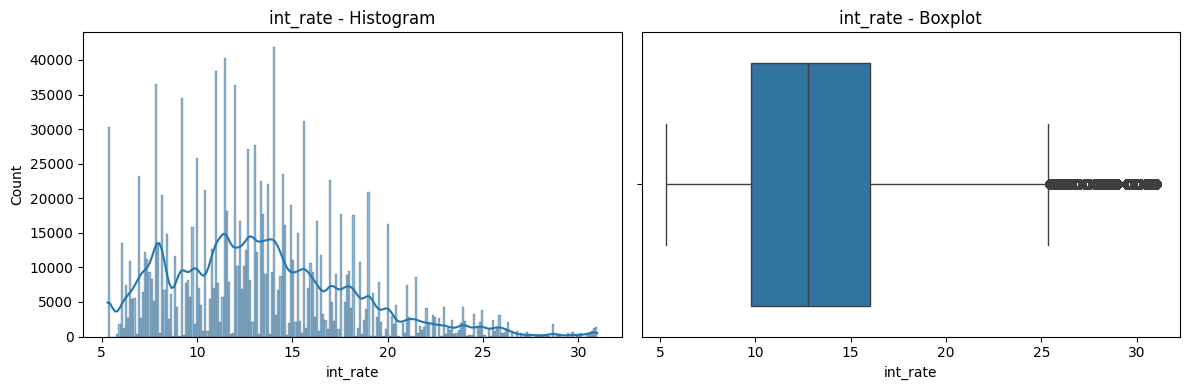

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = [
    'annual_inc', 'loan_amnt', 'installment', 'dti',
    'revol_util', 'open_acc', 'total_acc', 'fico_range_low',
    'inq_last_6mths', 'collections_12_mths_ex_med', 'int_rate'
]

for col in numeric_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(model_df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col} - Histogram")

    # Boxplot
    sns.boxplot(x=model_df[col], ax=axes[1])
    axes[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()


In [ ]:
from scipy import stats

z_scores = np.abs(stats.zscore(model_df[numeric_features]))
outlier_rows = (z_scores > 3).any(axis=1)
print(f'Number of potential outliers: {outlier_rows.sum()}')


Number of potential outliers: 96667


In [ ]:
print(model_df[numeric_features].describe())
print(model_df[numeric_features].skew())
print(model_df[numeric_features].kurtosis())

         annual_inc     loan_amnt   installment           dti    revol_util  \
count  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06   
mean   7.624757e+04  1.441997e+04  4.380756e+02  1.828245e+01  5.181003e+01   
std    6.992485e+04  8.717098e+03  2.615145e+02  1.115887e+01  2.451329e+01   
min    0.000000e+00  5.000000e+02  4.930000e+00 -1.000000e+00  0.000000e+00   
25%    4.578000e+04  8.000000e+03  2.484800e+02  1.179000e+01  3.350000e+01   
50%    6.500000e+04  1.200000e+04  3.754300e+02  1.761000e+01  5.220000e+01   
75%    9.000000e+04  2.000000e+04  5.807300e+02  2.405000e+01  7.070000e+01   
max    1.099920e+07  4.000000e+04  1.719830e+03  9.990000e+02  8.923000e+02   

           open_acc     total_acc  fico_range_low  inq_last_6mths  \
count  1.345350e+06  1.345350e+06    1.345350e+06    1.345349e+06   
mean   1.159351e+01  2.498075e+01    6.961853e+02    6.550761e-01   
std    5.473848e+00  1.199851e+01    3.185280e+01    9.377690e-01   
min    0.000

Extreme max values and broad ranges are present, especially for income and DTI. Many features exhibit right-skewed distributions.


---



*  Skewness > 1 (or <–1): Highly skewed; extreme for income (46.3), DTI (27.1), collections (14.9).

*  Kurtosis > 3: Heavy tails (many outliers); especially pronounced in income and DTI.

*  Several features (loan amount, FICO, installment, open accounts, inquiries) moderately skewed.

In [52]:
model_df[model_df['dti']<0]

,annual_inc,verification_status,emp_length,home_ownership,addr_state,dti,purpose,application_type,fico_range_low,fico_range_high,...,acc_now_delinq,num_tl_90g_dpd_24m,loan_amnt,int_rate,term,installment,grade,sub_grade,funded_amnt,loan_status
1014615,94000.0,Source Verified,5 years,MORTGAGE,OR,-1.0,debt_consolidation,Individual,670.0,674.0,...,0.0,0.0,15000.0,9.75,36 months,482.25,B,B3,15000.0,0
1681348,75000.0,Not Verified,10+ years,MORTGAGE,IN,-1.0,debt_consolidation,Joint App,685.0,689.0,...,0.0,0.0,17000.0,13.49,60 months,391.08,C,C2,17000.0,0


Negative DTI is invalid(data error) we gonna remove those rows

In [54]:
model_df = model_df[model_df['dti']>0]